# Simulation with default parameters, no hemoglobin reaction and periodic boundary conditions on slab mesh

The following notebook outlines a sample simulation of the perfusion and gas exchange model on a periodic mesh mimicking an infinite sheet positioned between alveoli (an approximation to the 2D problem, collapsing the $\boldsymbol{\hat{z}}$ axis). We start without considering hemoglobin effects.

Import necessary packages and add the working directory to the system path.

In [1]:
import sys
import os
import dolfin
import pandas as pd
import matplotlib.pyplot as plt
from ipygany import Scene, PolyMesh, ColorBar, IsoColor
from ipywidgets import Play, IntProgress, link, VBox
plt.style.use('ggplot')
sys.path.append(os.getcwd()[:-6])

Import the model modules.

In [2]:
from src.model import PerfusionGasExchangeModel
from src.params import params

Set a target folder for `vtk` files.

In [3]:
folder = "periodic-bcs-no-hb"
path = os.path.join("../raw-data", folder)

Instance the model and run simulation.

In [4]:
model = PerfusionGasExchangeModel(folder_path=path, params=params)
model.generate_slab_mesh(
    dims=(200, 6, 6), elems=(200, 6, 6), save=True, periodic=True
)
model.sim_p(save=True, meshtype="slab")
model.sim_sbst(hb=False, save=True)
boundaries = dolfin.File(model.folder_path+'/bnd/bnd.pvd')
boundaries << model.boundaries

Solving linear variational problem.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.970e+07 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.613e-08 (tol = 1.000e-10) r (rel) = 1.327e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


Read data into CSV files. We take the oxygen partial pressure along the capillary at three different heights ($y$).

In [6]:
middle = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/sbst/curve_middle_po2.csv'
)
quarter = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/sbst/curve_quarter_po2.csv'
)
top = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/sbst/curve_top_po2.csv'
)
middlec = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/sbst/curve_middle_pco2.csv'
)
quarterc = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/sbst/curve_quarter_pco2.csv'
)
topc = pd.read_csv(
    '../raw-data/periodic-bcs-no-hb/sbst/curve_top_pco2.csv'
)

And we visualize the results

In [7]:
if not os.path.isdir(os.path.join('../results-data/', folder)):
    os.makedirs(os.path.join('../results-data/', folder))

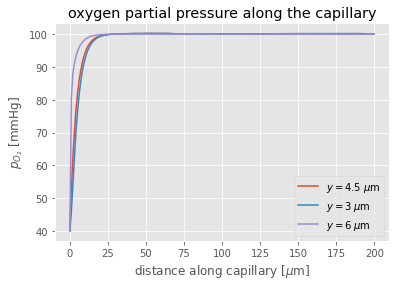

In [9]:
plt.figure()
plt.title('oxygen partial pressure along the capillary')
plt.ylabel(r'$p_{O_2}$ [mmHg]')
plt.xlabel(r'distance along capillary [$\mu$m]')
plt.plot(
    quarter["arc_length"], quarter["f_44-0"], label=r'$y=4.5 \; \mu$m'
)
plt.plot(
    middle["arc_length"], middle["f_44-0"], label=r'$y=3 \; \mu$m'
)
plt.plot(
    top["arc_length"], top["f_44-0"], label=r'$y=6 \; \mu$m'
)
plt.legend()
plt.savefig(os.path.join('../results-data/', folder, 'po2_along_cap.pdf'))

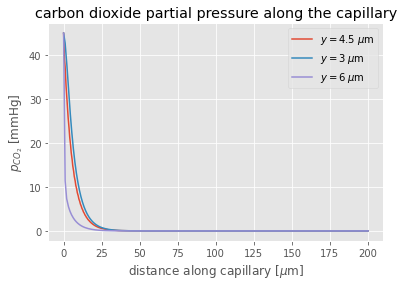

In [11]:
plt.figure()
plt.title('carbon dioxide partial pressure along the capillary')
plt.ylabel(r'$p_{CO_2}$ [mmHg]')
plt.xlabel(r'distance along capillary [$\mu$m]')
plt.plot(
    quarterc["arc_length"], quarterc["f_44-1"], label=r'$y=4.5 \; \mu$m'
)
plt.plot(
    middlec["arc_length"], middlec["f_44-1"], label=r'$y=3 \; \mu$m'
)
plt.plot(
    topc["arc_length"], topc["f_44-1"], label=r'$y=6 \; \mu$m'
)
plt.legend()
plt.savefig(os.path.join('../results-data/', folder, 'pco2_along_cap.pdf'))

Repeat with Hb action.

In [14]:
folder = "periodic-bcs-hb"
path = os.path.join("../raw-data", folder)
model = PerfusionGasExchangeModel(folder_path=path, params=params)
model.generate_slab_mesh(
    dims=(200, 6, 6), elems=(100, 3, 3), save=True, periodic=True
)
model.sim_p(save=True, meshtype="slab")
model.sim_sbst(hb=True, save=True)
boundaries = dolfin.File(model.folder_path+'/bnd/bnd.pvd')
boundaries << model.boundaries

  Solving linear variational problem.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.874e+07 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.960e-08 (tol = 1.000e-10) r (rel) = 7.641e-16 (tol = 1.000e-09)
    Newton solver finished in 1 iterations and 1 linear solver iterations.


In [19]:
middle = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_middle_po2.csv'
)
quarter = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_quarter_po2.csv'
)
top = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_top_po2.csv'
)
middlec = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_middle_pco2.csv'
)
quarterc = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_quarter_pco2.csv'
)
topc = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_top_pco2.csv'
)

middlehb = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_middle_hb02.csv'
)
quarterhb = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_quarter_hb02.csv'
)
tophb = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_top_hb02.csv'
)
middlehbc = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_middle_hbco2.csv'
)
quarterhbc = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_quarter_hbco2.csv'
)
tophbc = pd.read_csv(
    '../raw-data/periodic-bcs-hb/sbst/curve_top_hbco2.csv'
)

In [16]:
if not os.path.isdir(os.path.join('../results-data/', folder)):
    os.makedirs(os.path.join('../results-data/', folder))

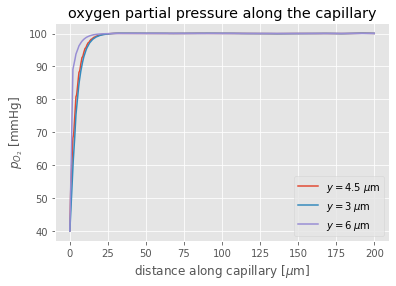

In [25]:
plt.figure()
plt.title('oxygen partial pressure along the capillary')
plt.ylabel(r'$p_{O_2}$ [mmHg]')
plt.xlabel(r'distance along capillary [$\mu$m]')
plt.plot(
    quarter["arc_length"], quarter["f_218-0"], label=r'$y=4.5 \; \mu$m'
)
plt.plot(
    middle["arc_length"], middle["f_218-0"], label=r'$y=3 \; \mu$m'
)
plt.plot(
    top["arc_length"], top["f_218-0"], label=r'$y=6 \; \mu$m'
)
plt.legend()
plt.savefig(os.path.join('../results-data/', folder, 'po2_along_cap.pdf'))

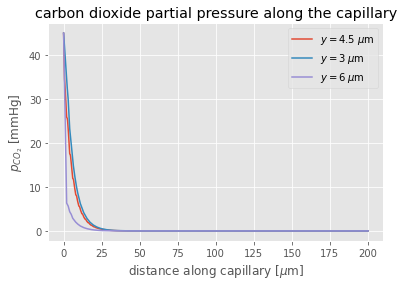

In [26]:
plt.figure()
plt.title('carbon dioxide partial pressure along the capillary')
plt.ylabel(r'$p_{CO_2}$ [mmHg]')
plt.xlabel(r'distance along capillary [$\mu$m]')
plt.plot(
    quarterc["arc_length"], quarterc["f_218-1"], label=r'$y=4.5 \; \mu$m'
)
plt.plot(
    middlec["arc_length"], middlec["f_218-1"], label=r'$y=3 \; \mu$m'
)
plt.plot(
    topc["arc_length"], topc["f_218-1"], label=r'$y=6 \; \mu$m'
)
plt.legend()
plt.savefig(os.path.join('../results-data/', folder, 'pco2_along_cap.pdf'))

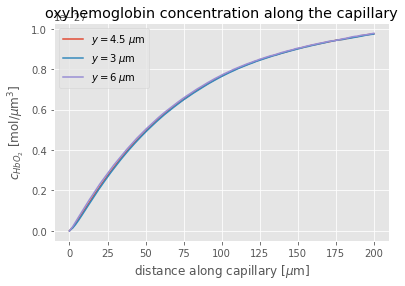

In [27]:
plt.figure()
plt.title('oxyhemoglobin concentration along the capillary')
plt.ylabel(r'$c_{HbO_2}$ [mol/$\mu$m$^3$]')
plt.xlabel(r'distance along capillary [$\mu$m]')
plt.plot(
    quarterhb["arc_length"], quarterhb["f_218-2"], label=r'$y=4.5 \; \mu$m'
)
plt.plot(
    middlehb["arc_length"], middlehb["f_218-2"], label=r'$y=3 \; \mu$m'
)
plt.plot(
    tophb["arc_length"], tophb["f_218-2"], label=r'$y=6 \; \mu$m'
)
plt.legend()
plt.savefig(os.path.join('../results-data/', folder, 'chbo2_along_cap.pdf'))

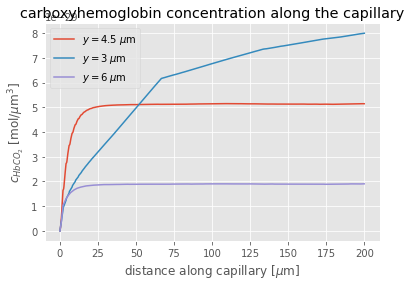

In [28]:
plt.figure()
plt.title('carboxyhemoglobin concentration along the capillary')
plt.ylabel(r'$c_{HbCO_2}$ [mol/$\mu$m$^3$]')
plt.xlabel(r'distance along capillary [$\mu$m]')
plt.plot(
    quarterhbc["arc_length"], quarterhbc["f_218-3"], label=r'$y=4.5 \; \mu$m'
)
plt.plot(
    middlehbc["arc_length"], middlehbc["f_218-3"], label=r'$y=3 \; \mu$m'
)
plt.plot(
    tophbc["arc_length"], tophbc["f_218-3"], label=r'$y=6 \; \mu$m'
)
plt.legend()
plt.savefig(os.path.join('../results-data/', folder, 'chbco2_along_cap.pdf'))